In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (correlation_2op_2t, destroy, fock_dm, qeye, tensor)

from torchqc.states import QuantumState
from torchqc.operators import Operator
from torchqc.correlation import spectrum, correlation_fn_2op_1time
from torchqc.common_matrices import annihilation, eye, sigmaMinus, sigmaPlus
from torchqc.tensor_product import tensor_product_ops
import qutip
import torch

%matplotlib inline

$S(\omega) = \int_{-\infty}^{\infty} \left<A(\tau)B(0)\right> e^{-i\omega\tau} d\tau.$

In [2]:
N = 4                      # number of cavity fock states
wc = wa = 1.0 * 2 * np.pi  # cavity and atom frequency
g  = 0.1 * 2 * np.pi       # coupling strength
kappa = 0.75               # cavity dissipation rate
gamma = 0.25               # atom dissipation rate

In [3]:
# Jaynes-Cummings Hamiltonian
a  = qutip.tensor(qutip.destroy(N), qutip.qeye(2))
sm = qutip.tensor(qutip.qeye(N), qutip.destroy(2))
H = wc*a.dag()*a + wa*sm.dag()*sm + g*(a.dag()*sm + a*sm.dag())

# collapse operators
n_th = 0.25
c_ops = [
    np.sqrt(kappa * (1 + n_th)) * a,
    np.sqrt(kappa * n_th) * a.dag(),
    np.sqrt(gamma) * sm,
]

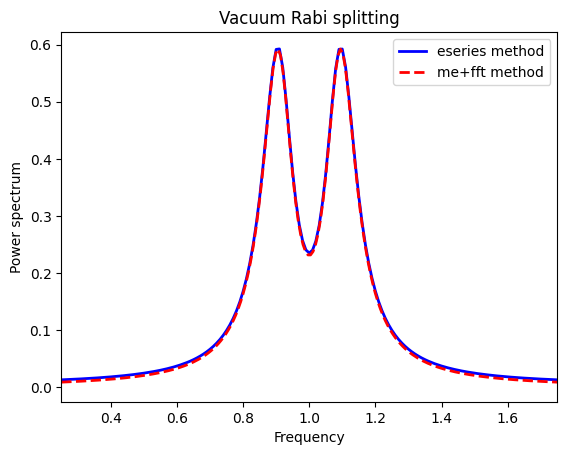

In [4]:
# calculate the correlation function using the mesolve solver, and then fft to
# obtain the spectrum. Here we need to make sure to evaluate the correlation
# function for a sufficient long time and sufficiently high sampling rate so 
# that the discrete Fourier transform (FFT) captures all the features in the
# resulting spectrum.
T = 100
steps = 5000
tlist = np.linspace(0, 100, 5000)
Dt = T / steps
corr = qutip.correlation_2op_1t(H, None, tlist, c_ops, a.dag(), a)

wlist1, spec1 = qutip.spectrum_correlation_fft(tlist, corr)

# calculate the power spectrum using spectrum, which internally uses essolve
# to solve for the dynamics (by default)
wlist2 = np.linspace(0.25, 1.75, 200) * 2 * np.pi
spec2 = qutip.spectrum(H, wlist2, c_ops, a.dag(), a)

# plot the spectra
fig, ax = plt.subplots(1, 1)
ax.plot(wlist1 / (2 * np.pi), spec1, 'b', lw=2, label='eseries method')
ax.plot(wlist2 / (2 * np.pi), spec2, 'r--', lw=2, label='me+fft method')
ax.legend()
ax.set_xlabel('Frequency')
ax.set_ylabel('Power spectrum')
ax.set_title('Vacuum Rabi splitting')
ax.set_xlim(wlist2[0]/(2*np.pi), wlist2[-1]/(2*np.pi))
plt.show()

* torchqc calculation

In [5]:
a = tensor_product_ops(annihilation(N), eye(2))
a_dagger = a.dagger()
sm = tensor_product_ops(eye(N), sigmaMinus())
sp = tensor_product_ops(eye(N), sigmaPlus())

H = wc * a_dagger * a + wa * sp * sm + g * (a_dagger * sm + a * sp)

jump_ops = [a, a_dagger, sm]
rates = [kappa * (1 + n_th), kappa * n_th, gamma]

corr_torchqc = correlation_fn_2op_1time(H, None, tlist, Dt, a_dagger, a, jump_ops, rates)

In [6]:
wlist_torchqc, spec_torchqc = spectrum(corr_torchqc, tlist)

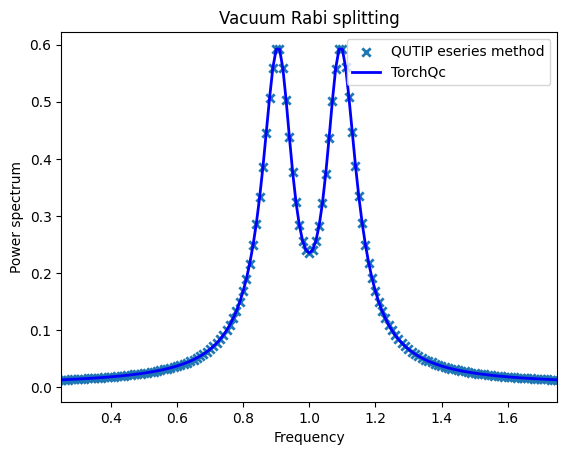

In [8]:
# plot the spectra
fig, ax = plt.subplots(1, 1)
ax.scatter(wlist1 / (2 * np.pi), spec1, marker="x", lw=2, label='QUTIP eseries method')
ax.plot(wlist_torchqc / (2 * np.pi), spec_torchqc, 'b', lw=2, label='TorchQc')
ax.legend()
ax.set_xlabel('Frequency')
ax.set_ylabel('Power spectrum')
ax.set_title('Vacuum Rabi splitting')
ax.set_xlim(0.25, 1.75)
plt.show()